# ML for wage prediction

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as  pd, numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
url = "https://raw.githubusercontent.com/d2cml-ai/14.388_r/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(url).drop(columns=["rownames"])
data.head()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600.0,11,8370.0,18
1,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050.0,10,5070.0,9
2,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260.0,19,770.0,4
3,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420.0,1,6990.0,12
4,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015.0,6,9470.0,22


The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [3]:
Z = data.drop(columns=['lwage', 'wage']) # regressors
print(Z.columns)

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')


The following figure shows the weekly wage distribution from the US survey data.

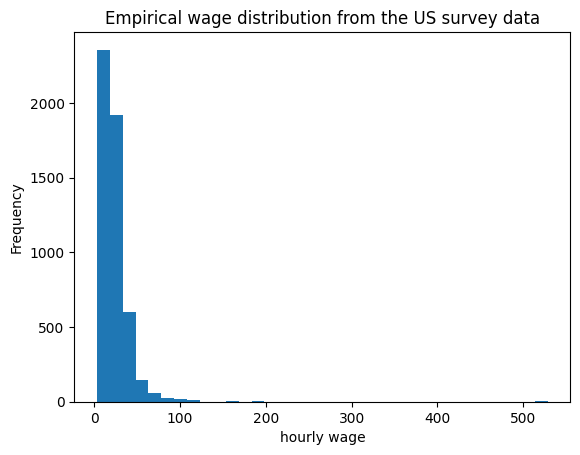

In [4]:
plt.hist(data['wage'], bins=35, label='hourly wage')
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title('Empirical wage distribution from the US survey data')
plt.show()

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:
 
1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [5]:
np.random.seed(1234)
training = np.random.choice(data.index, size=int(len(data)*(3/4)), replace=False)

data_train = data.loc[training,:]
data_test = data.drop(training, axis=0)

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [6]:
import statsmodels.formula.api as smf
import patsy

In [7]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, x_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')
y_basic_test, x_basic_test = patsy.dmatrices(formula_basic, data_test, return_type='dataframe')
p_basic = x_basic_train.shape[ 1 ]

y_flex_train, x_flex_train = patsy.dmatrices(formula_flex, data_train, return_type='dataframe')
y_flex_test, x_flex_test = patsy.dmatrices(formula_flex, data_test, return_type='dataframe')
p_flex = x_flex_train.shape[ 1 ]

In [8]:
Y_train = data_train['lwage']
Y_test = data_test['lwage']

In [9]:
p_basic, p_flex

(13, 51)

As known from our first lab, the basic model consists of $10$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression. 

### OLS

We fit the basic model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [10]:
x_basic_train.head()

,Intercept,sex,exp1,exp2,shs,hsg,scl,clg,mw,so,we,occ2,ind2
4595,1.0,1.0,12.0,1.44,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0
5009,1.0,1.0,12.0,1.44,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,17.0
3730,1.0,1.0,12.0,1.44,0.0,1.0,0.0,0.0,0.0,1.0,0.0,16.0,9.0
179,1.0,0.0,29.0,8.41,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,14.0
1323,1.0,1.0,12.0,1.44,0.0,1.0,0.0,0.0,1.0,0.0,0.0,22.0,5.0


In [11]:
fit_lm_basic = smf.ols(formula_basic, data = data_train).fit()

In [12]:
yhat_lm_basic = fit_lm_basic.predict(data_test)
print("The mean squared error (MSE) using the basic model is equal to", ((Y_test - yhat_lm_basic)**2).mean())


The mean squared error (MSE) using the basic model is equal to 0.25113575025351914


To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [13]:
resid_basic  = (Y_test - yhat_lm_basic)**2

MSE_lm_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_basic

Coef.       0.251136
Std.Err.    0.016115
Name: const, dtype: float64

We also compute the out-of-sample $R^2$:

In [14]:
R2_lm_basic = 1 - ( MSE_lm_basic[0]/Y_test.var() )
print( f"The R^2 using the basic model is equal to, {R2_lm_basic}" ) # MSE OLS (basic model) 

The R^2 using the basic model is equal to, 0.2335579652253298


We repeat the same procedure for the flexible model.

In [15]:
# ols (flex model)
lm_flex = sm.OLS(Y_train, x_flex_train)
fit_lm_flex = lm_flex.fit()

yhat_lm_flex = fit_lm_flex.predict(x_flex_test)

resid_flex = (Y_test-yhat_lm_flex)**2

MSE_lm_flex = sm.OLS(resid_flex , np.ones(resid_flex.shape[0])).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_flex

R2_lm_flex = 1 - (MSE_lm_flex[0]/Y_test.var())
print(f"The R^2 using the flex model is equal to, {R2_lm_flex}") # MSE OLS (flex model) 

The R^2 using the flex model is equal to, 0.22646565124243312


We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


Considering the basic model, we run a lasso/post-lasso regression first and then we compute the measures for the out-of-sample performance. Note that applying the package *hdm* and the function *rlasso* we rely on a theory-based choice of the penalty level $\lambda$ in the lasso regression.

In [16]:
import hdmpy as hdm

In [17]:
fit_rlasso = hdm.rlasso(x_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post = hdm.rlasso(x_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\nump

So we have to apply those transfomations to original test data, `(post = False)`

In [18]:
# Getting mean of each variable
meanx = x_basic_test.mean( axis = 0 ).values.\
                        reshape( x_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = x_basic_test.to_numpy() - \
                    (np.ones( ( x_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso = new_x1[ :, fit_rlasso.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso = fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso = (x1_est_rlasso @ beta_rlasso) + np.mean( Y_test.to_numpy() )
residuals_rlasso = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso

Apply those transfomations to original test data, `(post = True)`

In [19]:
# Getting mean of each variable
meanx = x_basic_test.mean( axis = 0 ).values.\
                        reshape(x_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = x_basic_test.to_numpy() - \
                    (np.ones( (x_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post = new_x1[ :, fit_rlasso_post.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post = fit_rlasso_post.est['beta'].loc[ fit_rlasso_post.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post = (x1_est_rlasso_post @ beta_rlasso_post) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post

In [20]:
MSE_lasso = sm.OLS( ( residuals_rlasso )**2 , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ( residuals_rlasso_post )**2  , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

R2_lasso = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post = 1 - MSE_lasso_post.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso},for lasso and {R2_lasso_post} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.2089428603664083,for lasso and 0.21505140970720815 for post-lasso


Now, we repeat the same procedure for the flexible model.

In [21]:
fit_rlasso_flex = hdm.rlasso(x_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post_flex = hdm.rlasso(x_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\nump

In [22]:
# Getting mean of each variable
meanx = x_flex_test.mean( axis = 0 ).values.\
                        reshape(x_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = x_flex_test.to_numpy() - \
                    (np.ones( (x_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_flex = new_x1[ :, fit_rlasso_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_flex = fit_rlasso_flex.est['beta'].loc[ fit_rlasso_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_flex = (x1_est_rlasso_flex @ beta_rlasso_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_flex

# Getting mean of each variable
meanx = x_flex_test.mean( axis = 0 ).values.\
                        reshape(x_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = x_flex_test.to_numpy() - \
                    (np.ones( (x_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post_flex = new_x1[ :, fit_rlasso_post_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post_flex = fit_rlasso_post_flex.est['beta'].loc[ fit_rlasso_post_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post_flex = (x1_est_rlasso_post_flex @ beta_rlasso_post_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post_flex

In [23]:
MSE_lasso_flex = sm.OLS( ( residuals_rlasso_flex )**2 , np.ones( yhat_rlasso_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post_flex = sm.OLS( ( residuals_rlasso_post_flex )**2  , np.ones( yhat_rlasso_post_flex.size )  ).fit().summary2().tables[1].round(3)

R2_lasso_flex = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post_flex = 1 - MSE_lasso_post_flex.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso_flex},for lasso and {R2_lasso_post_flex} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.2089428603664083,for lasso and 0.21505140970720815 for post-lasso


In contrast to a theory-based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [24]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

fit_lasso_cv = LassoCV(cv=10, fit_intercept=True, normalize=False, random_state=0).fit(x_basic_train, Y_train)
fit_ridge = RidgeCV(cv=10, fit_intercept=True, normalize=False, scoring=None).fit(x_basic_train, Y_train)
fit_elnet = ElasticNetCV(cv=10, fit_intercept=True, normalize=False, random_state=0).fit(x_basic_train, Y_train)

yhat_lasso_cv = fit_lasso_cv.predict(x_basic_test)
yhat_ridge = fit_ridge.predict(x_basic_test)
yhat_elnet = fit_elnet.predict(x_basic_test)

residual_lasso = (yhat_lasso_cv - Y_test)**2
residual_ridge = (yhat_ridge - Y_test)**2
residual_elnet = (yhat_elnet - Y_test)**2

MSE_lasso_cv = sm.OLS(residual_lasso, np.ones(Y_test.size)).fit().summary2().tables[1].round(3)
MSE_ridge = sm.OLS(residual_ridge, np.ones(Y_test.size)).fit().summary2().tables[1].round(3)
MSE_elnet = sm.OLS(residual_elnet, np.ones(Y_test.size)).fit().summary2().tables[1].round(3)

# R2_lasso_cv_flex = 1 - MSE_lasso_cv.iloc[0, 0] / np.var(Y_test)
# R2_ridge_flex = 1 - MSE_ridge.iloc[0, 0] / np.var(Y_test)
# R2_elnet_flex = 1 - MSE_elnet.iloc[0, 0] / np.var(Y_test)

# yhat_lasso_cv = fit_lasso_cv.predict(x_basic_test)
# yhat_ridge = fit_ridge.predict(x_basic_test)
# yhat_elnet = fit_elnet.predict(x_basic_test)

# MSE_lasso_cv = mean_squared_error(Y_test, yhat_lasso_cv)
# MSE_ridge = mean_squared_error(Y_test, yhat_ridge)
# MSE_elnet = mean_squared_error(Y_test, yhat_elnet)

R2_lasso_cv = 1 - MSE_lasso_cv.iloc[0, 0] / np.var(Y_test)
R2_ridge = 1 - MSE_ridge.iloc[0, 0]  / np.var(Y_test)
R2_elnet = 1 - MSE_elnet.iloc[0, 0]  / np.var(Y_test)

print("R^2 using cross-validation for lasso, ridge, and elastic net in the basic model: {:.5f}, {:.5f}, {:.5f}".format(R2_lasso_cv, R2_ridge, R2_elnet))


R^2 using cross-validation for lasso, ridge, and elastic net in the basic model: 0.23032, 0.23338, 0.23032


c:\Python38\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Python38\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to 

Note that the following calculations for the flexible model require significant computation time.

In [25]:
fit_lasso_cv_flex = LassoCV(cv=10, fit_intercept=True, normalize=False, random_state=0).fit(x_flex_train, Y_train)
fit_ridge_flex = RidgeCV(cv=10, fit_intercept=True, normalize=False, scoring=None).fit(x_flex_train, Y_train)
fit_elnet_flex = ElasticNetCV(cv=10, fit_intercept=True, normalize=False, random_state=0).fit(x_flex_train, Y_train)

yhat_lasso_cv_flex = fit_lasso_cv_flex.predict(x_flex_test)
yhat_ridge_flex = fit_ridge_flex.predict(x_flex_test)
yhat_elnet_flex = fit_elnet_flex.predict(x_flex_test)

residual_lasso_flex = (yhat_lasso_cv_flex - Y_test)**2
residual_ridge_flex = (yhat_ridge_flex - Y_test)**2
residual_elnet_flex = (yhat_elnet_flex - Y_test)**2

MSE_lasso_cv_flex = sm.OLS(residual_lasso_flex, np.ones(Y_test.size)).fit().summary2().tables[1].round(3)
MSE_ridge_flex = sm.OLS(residual_ridge_flex, np.ones(Y_test.size)).fit().summary2().tables[1].round(3)
MSE_elnet_flex = sm.OLS(residual_elnet_flex, np.ones(Y_test.size)).fit().summary2().tables[1].round(3)

R2_lasso_cv_flex = 1 - MSE_lasso_cv_flex.iloc[0, 0] / np.var(Y_test)
R2_ridge_flex = 1 - MSE_ridge_flex.iloc[0, 0] / np.var(Y_test)
R2_elnet_flex = 1 - MSE_elnet_flex.iloc[0, 0] / np.var(Y_test)

print("R^2 using cross-validation for lasso, ridge, and elastic net in the basic model: {:.3f}, {:.3f}, {:.3f}".format(R2_lasso_cv, R2_ridge, R2_elnet))

c:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16581324345997928, tolerance: 0.11146464292939776
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1678078988946936, tolerance: 0.11146464292939776
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16363316256570215, tolerance: 0.11146464292939776
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not conve

R^2 using cross-validation for lasso, ridge, and elastic net in the basic model: 0.230, 0.233, 0.230


The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are apply regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. First, we load the relevant libraries.

and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

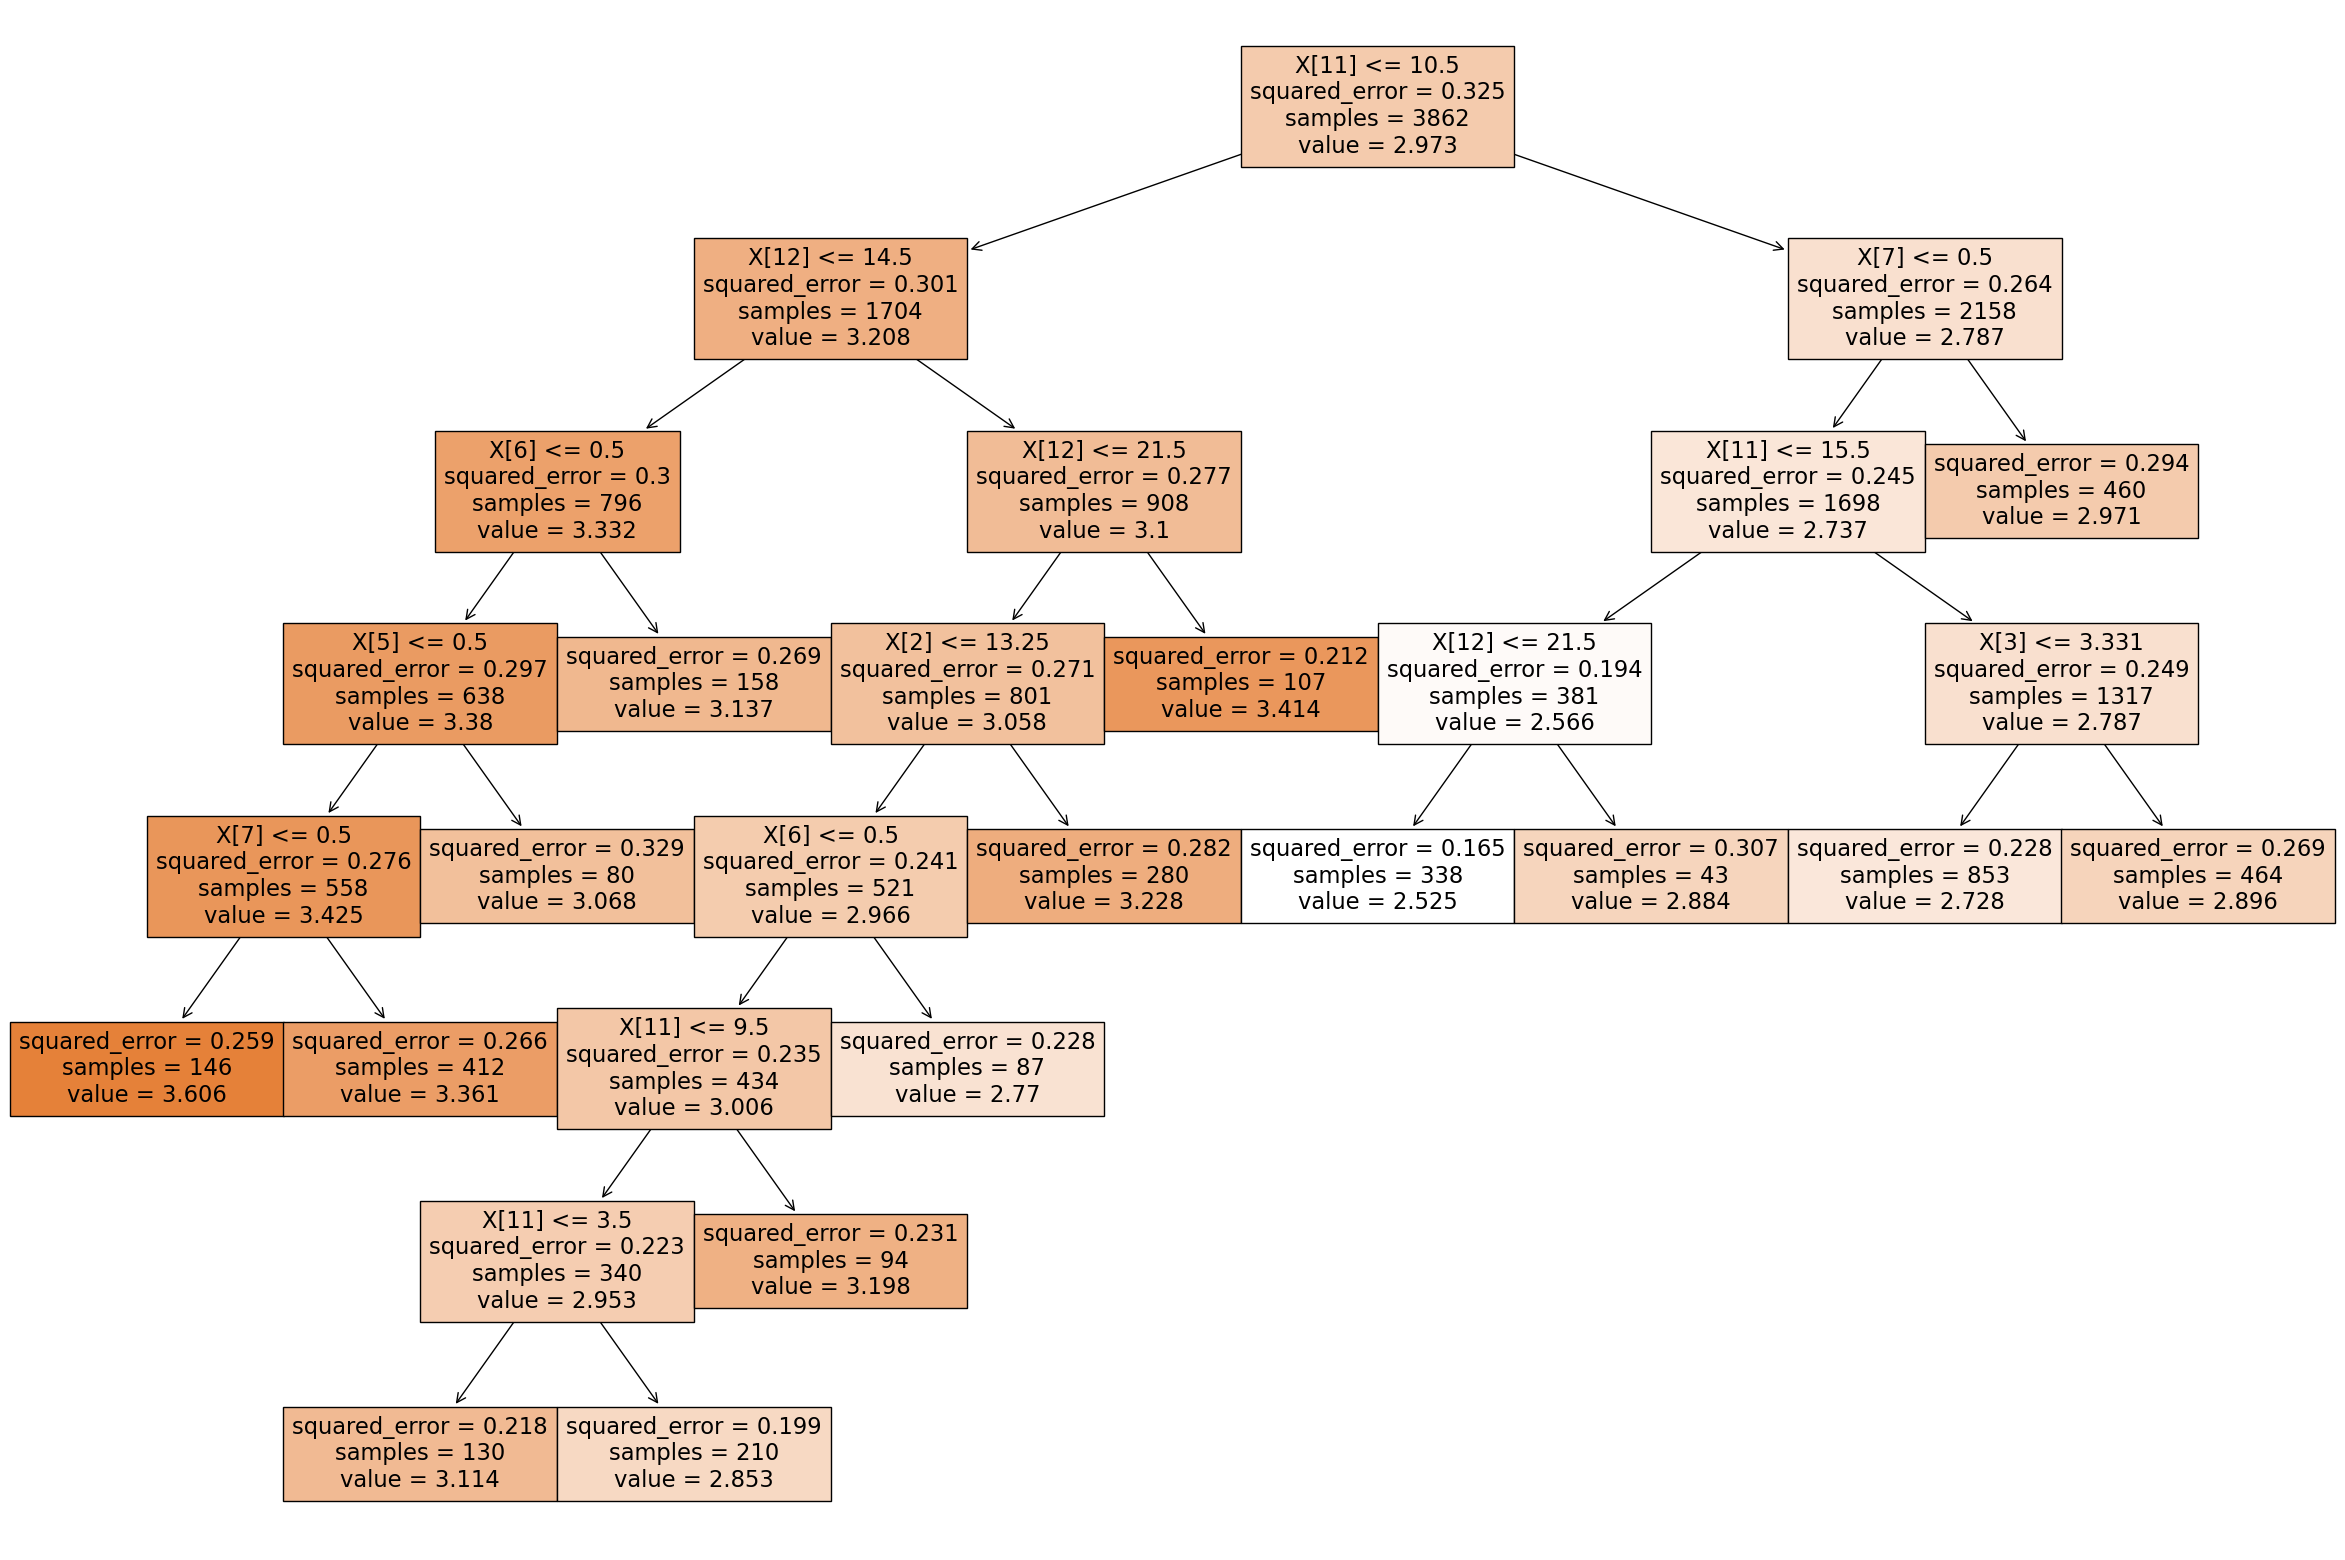

In [27]:
fit_trees = DecisionTreeRegressor(random_state = 0, min_impurity_decrease = 0.001)
fit_trees.fit(x_basic_train, y_basic_train)
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 20))
plot_tree(fit_trees, filled=True)
plt.show()

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [28]:
s = pd.DataFrame(fit_trees.cost_complexity_pruning_path(y_basic_train, x_basic_train ))
s.head()

,ccp_alphas,impurities
0,0.000000,11.627846
1,0.001011,11.628857
2,0.001024,11.629881
3,0.001024,11.630906
4,0.001036,11.631941


Now, we can prune the tree and visualize the prediction rule.

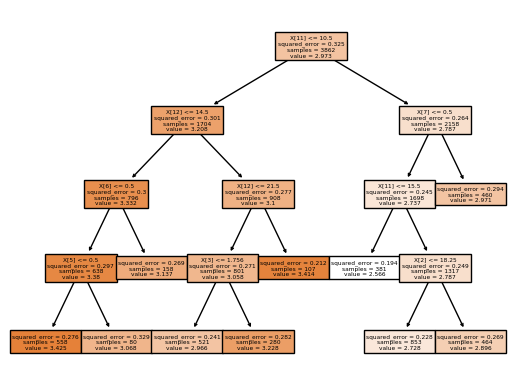

In [29]:
fit_prunnedtree = DecisionTreeRegressor(ccp_alpha=0.00188444410871555)
fit_prunnedtree.fit(x_basic_train, y_basic_train)
# plt.figure(figsize=(30, 20))
plot_tree(fit_prunnedtree, filled=True)
plt.show()

Finally, we calculate the mean-squared error and the $R^2$ on the test sample to evaluate the out-of-sample performance of the pruned tree.

In [30]:
y_hat_pt = fit_prunnedtree.predict(x_basic_test)
residual_pt = (y_hat_pt - Y_test)**2
MSE_pt = sm.OLS(residual_pt, np.ones(y_hat_pt.size)).fit().summary2().tables[1].round(3)
R2_pt = 1 - MSE_pt.iloc[0, 0]/ np.var( Y_test )
print(f"R^2 of the pruned tree: {R2_pt}")

R^2 of the pruned tree: 0.19978003635520836


### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods: random forest and boosted trees.

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 

In [32]:
# Applying the methods
# random forest
fit_rf = RandomForestRegressor(n_estimators=2000, min_samples_leaf=5).fit(x_basic_train, Y_train)

# boosting
fit_boost = GradientBoostingRegressor(loss='ls', learning_rate=0.01, n_estimators=1000, max_depth=2, subsample=0.5).fit(x_basic_train, Y_train)

# Evaluating the methods
yhat_rf = fit_rf.predict(x_basic_test)
residual_rf = (yhat_rf - Y_test)**2
yhat_boost = fit_boost.predict(x_basic_test)
residual_bst = (yhat_boost - Y_test)**2


MSE_rf = sm.OLS(residual_pt, np.ones(yhat_rf.size)).fit().summary2().tables[1].round(3)
MSE_bst = sm.OLS(residual_bst, np.ones(yhat_boost.size)).fit().summary2().tables[1].round(3)


R2_rf = 1 - MSE_rf.iloc[0, 0] / Y_test.var()
R2_boost = 1 - MSE_bst.iloc[0, 0] / Y_test.var()



c:\Python38\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [33]:
print("R^2 of the random forest and boosted trees:{:.5f}, {:.5f}".format(R2_rf, R2_boost))

R^2 of the random forest and boosted trees:0.20040, 0.28585


To conclude, let us have a look at our results.

## Results

In [34]:
table = pd.DataFrame(columns=["MSE", "S.E for MSE", "R-squared"]) 
table.loc[0]  = [MSE_lm_basic[0], MSE_lm_basic[1], R2_lm_basic]
table.loc[1]  = [MSE_lm_flex[0], MSE_lm_flex[1], R2_lm_flex]
table.loc[2]  = [MSE_lasso.iloc[0, 0], MSE_lasso.iloc[0, 1], R2_lasso]
table.loc[3]  = [MSE_lasso_post.iloc[0, 0], MSE_lasso_post.iloc[0, 1], R2_lasso_post]
table.loc[4]  = [MSE_lasso_flex.iloc[0, 0], MSE_lasso_flex.iloc[0, 1], R2_lasso_flex]
table.loc[5]  = [MSE_lasso_post_flex.iloc[0, 0], MSE_lasso_post_flex.iloc[0, 1], R2_lasso_post_flex]
table.loc[6]  = [MSE_lasso_cv.iloc[0, 0], MSE_lasso_cv.iloc[0, 1], R2_lasso_cv]
table.loc[7]  = [MSE_ridge.iloc[0, 0], MSE_ridge.iloc[0, 1], R2_ridge]
table.loc[8]  = [MSE_elnet.iloc[0, 0], MSE_elnet.iloc[0, 1], R2_elnet]
table.loc[9]  = [MSE_lasso_cv_flex.iloc[0, 0], MSE_lasso_cv_flex.iloc[0, 1], R2_lasso_cv_flex]
table.loc[10] = [MSE_ridge_flex.iloc[0, 0], MSE_ridge_flex.iloc[0, 1], R2_ridge_flex]
table.loc[11] = [MSE_elnet_flex.iloc[0, 0], MSE_elnet_flex.iloc[0, 1], R2_elnet_flex]
table.loc[12] = [MSE_rf.iloc[0, 0], MSE_rf.iloc[0, 1], R2_rf]
table.loc[13] = [MSE_bst.iloc[0, 0], MSE_bst.iloc[0, 1], R2_boost]
table.loc[14] = [MSE_pt.iloc[0, 0], MSE_pt.iloc[0, 1], R2_pt]
models_row = ["Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", 
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  
                    "Random Forest","Boosted Trees", "Pruned Tree"]
table.insert(0, "Models", models_row)
table

,Models,MSE,S.E for MSE,R-squared
0,Least Squares (basic),0.251136,0.016115,0.233558
1,Least Squares (flexible),0.253460,0.016007,0.226466
2,Lasso,0.259000,0.016000,0.208943
3,Post-Lasso,0.257000,0.016000,0.215051
4,Lasso (flexible),0.260000,0.016000,0.208943
5,Post-Lasso (flexible),0.257000,0.016000,0.215051
6,Cross-Validated lasso,0.252000,0.016000,0.230323
7,Cross-Validated ridge,0.251000,0.016000,0.233377
8,Cross-Validated elnet,0.252000,0.016000,0.230323
9,Cross-Validated lasso (flexible),0.259000,0.016000,0.208943


Above, we have displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$ in column 3. 

We see that the prediction rule produced by the Elastic Net using the flexible model performs the best here, giving the lowest test MSE. Cross-Validated Lasso and Ridge, perform nearly as well. For any two of these methods, their testing MSEs are within one standard error of each other. Remarkably, OLS on a simple model performs extremely well, almost as well as best tree based method Random Forest. On the other hand, OLS on a flexible model with many regressors performs very poorly giving the highest test MSE. Notice that the nonlinear models, e.g. Random Forest, are not tuned. Thus, there is a lot of potential to improve the performance of the nonlinear methods we used in the analysis.

## Ensemble learning

In the final step, we can build a prediction model by combining the strengths of the models we considered so far. This ensemble method is of the form

$$ f(x) = \sum_{k=1}^K \alpha_k f_k(x) $$
    
where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights.

We focus on the prediction rules based on OLS, Post-Lasso, Elastic Net, Pruned Tree, Random Forest, Boosted Trees, and Neural Network and combine these methods into an ensemble method. The appropriate weights can be determined by a simple ols regression:

In [35]:
esemble_df = pd.DataFrame()
esemble_df["y_test"] = Y_test
esemble_df["yhat_lm_basic"] = yhat_lm_basic
esemble_df["yhat_rlasso_post_flex"] = yhat_rlasso_post_flex.flatten()
esemble_df["yhat_elnet_flex"] = yhat_elnet_flex
esemble_df["y_hat_pt"] = y_hat_pt
esemble_df["yhat_rf"] = yhat_rf
esemble_df["yhat_boost"] = yhat_boost
esemble_df
cvt = [
  "yhat_lm_basic", "yhat_rlasso_post_flex", "yhat_elnet_flex", "y_hat_pt", "yhat_rf", "yhat_boost"
]

In [36]:
ols_esemble = smf.ols("y_test ~ 1 +" + " + ".join(cvt), data = esemble_df).fit().summary2()
ols_esemble

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:               OLS               Adj. R-squared:      0.311    
Dependent Variable:  y_test            AIC:                 1746.1107
Date:                2023-02-03 13:23  BIC:                 1782.2366
No. Observations:    1288              Log-Likelihood:      -866.06  
Df Model:            6                 F-statistic:         97.62    
Df Residuals:        1281              Prob (F-statistic):  3.74e-101
R-squared:           0.314             Scale:               0.22591  
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             -0.0642   0.1671 -0.3840 0.7010 -0.3920  0.2636
yhat_lm_basic          0.2686   0.2212  1.2145 0.2248 -0.1653  0.7025
yhat_rlasso_post_flex -0.4541   0.2093 -2.1690 0.0303 -0.8648 -0.0434
yhat_elnet_flex        0.0385   0.1552  0.2482 0.8040 -0.2659  0.3429
y_hat_pt              -0.3557   0.1130 -3.1481 0.0017 -0.5774 -0.1340
yhat_rf                0.4789   0.0918  5.2158 0.0000  0.2988  0.6591
yhat_boost             1.0432   0.1897  5.4979 0.0000  0.6710  1.4155
---------------------------------------------------------------------
Omnibus:              129.406        Durbin-Watson:           1.907  
Prob(Omnibus):        0.000          Jarque-Bera (JB):        702.846
Skew:                 0.283          Prob(JB):                0.000  
Kurtosis:             6.575          Condition No.:           159    
=====================================================================

"""

Alternatively, we can determine the weights via lasso regression. 

In [37]:
esemble_df['ones'] = np.ones(len(esemble_df))
cvt += ["ones"]

rlasso_essemble = hdm.rlasso(esemble_df[cvt].to_numpy(), esemble_df["y_test"].to_numpy().reshape(esemble_df["y_test"].size, 1))

c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python38\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [38]:
beta_rlasso = rlasso_essemble.est["beta"]
beta_rlasso

,0
V1,0.000000
V2,0.000000
V3,0.000000
V4,0.000000
V5,0.480044
V6,0.603145
V7,0.000000


The estimated weights are shown in the following table.

In [39]:
table1 = pd.DataFrame()
nam_row = ["Constant","Least Squares (basic)","Post-Lasso (flexible)", "Cross-Validated elnet (flexible)", "Pruned Tree",
                    "Random Forest","Boosted Trees"]
table1.insert(0, "Models", nam_row)
table1["Weight OLS"] = ols_esemble.tables[1].iloc[:, 0].to_numpy()
table1["Weight Lasso"] = beta_rlasso.to_numpy()
table1

,Models,Weight OLS,Weight Lasso
0,Constant,-0.064173,0.000000
1,Least Squares (basic),0.268603,0.000000
2,Post-Lasso (flexible),-0.454071,0.000000
3,Cross-Validated elnet (flexible),0.038513,0.000000
4,Pruned Tree,-0.355718,0.480044
5,Random Forest,0.478922,0.603145
6,Boosted Trees,1.043210,0.000000


Further, the $R^2$ for the test sample improves from $30\%$ obtained by OLS to about $31\%$ obtained by the ensemble method. We see that it is very powerful to aggregate prediction rules into an ensemble rule. Nevertheless, it is worth noticing that we should compare the ensemble method and the single rules on an additional validation set to ensure a fair comparison.